In [1580]:
from vedo import *
from ipyvtklink.viewer import ViewInteractiveWidget
#needed for running on laptop~~~~~
from vedo import settings
settings.default_backend = 'vtk'
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
import numpy as np
# import tensorflow as tf
from scipy.spatial.transform import Rotation as R

import gtsam
import gtsam.utils.plot as gtsam_plot
from gtsam import Pose3, Rot3, Point3
from pose_graph_utils import *
import tensorflow as tf
from tensorflow import  sin, cos, tan

import numpy as np
from matplotlib import pyplot as p
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Draw frames from odometry constraints

In [1710]:
#load relative poses from odometry file
# constraints = np.loadtxt("apartment/pose_data.csv", delimiter=',',skiprows=1)
constraints = np.loadtxt("pose_data.csv", delimiter=',',skiprows=1)

# print(constraints[:,0] == 1)
# print(constraints[:,:3])

odom_raw = constraints[constraints[:,0] == 0][:,1:]  # raw odometry constraints 
sr_raw = constraints[constraints[:,0] == 1][:,1:]    # sequential registration of keyframe constraints
lc_raw = constraints[constraints[:,0] == 2][:,1:]    # loop closure constraints
dc_raw = constraints[constraints[:,0] == 3][:,1:]    # dense constraint seeds (passed to loop closer node)

# odom_raw = sr_raw #DEBUG-- uncomment to draw SR traj ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
# odom_raw = odom_raw[:(len(odom_raw)//2)]
print(len(odom_raw))
#convert to rotation matrix
odom = np.zeros([len(odom_raw),4,4])
odom[0] = np.eye(4)
for i in range(1,len(odom_raw)):
    odom[i] = np.eye(4)
    curr = np.eye(4)
    #Full 6DOF transform
#     curr[:3,:3] = R.from_quat(odom_raw[i,5:]).as_matrix() #scipy depreciated syntax :(
    curr[:3,:3] = R.from_quat(odom_raw[i,5:]).as_dcm() 
#     #Suppress Pitch and Roll
#     full_rot = R.from_quat(odom_raw[i,5:]).as_euler('xyz')
#     curr[:3,:3] = R.from_euler('xyz', [0,0,full_rot[2]]).as_matrix()

    curr[:3,-1] = odom_raw[i,2:5]
    #forward conga line (works)
    for j in range(i):
        odom[j] = curr @ odom[j]    

#bring back to map frame
OG = odom[0].copy()
for j in range(len(odom_raw)):
    odom[j] = np.linalg.pinv(OG) @ odom[j]
        
sr = np.zeros([len(sr_raw),4,4])
sr[0] = np.eye(4)
for i in range(len(sr_raw)):
    sr[i] = np.eye(4)
    curr = np.eye(4)
    #FULL DOF
#     curr[:3,:3] = R.from_quat(sr_raw[i,5:]).as_matrix()
    curr[:3,:3] = R.from_quat(sr_raw[i,5:]).as_dcm()
#     #Suppress Pitch and Roll
#     full_rot = R.from_quat(sr_raw[i,5:]).as_euler('xyz')
#     curr[:3,:3] = R.from_euler('xyz', [0,0,full_rot[2]]).as_matrix()    
    curr[:3,-1] = sr_raw[i,2:5]
    for j in range(i+1):
        sr[j] = curr @ sr[j]

144


In [1714]:
plt = Plotter(N = 1, axes = 0, bg = (1, 1, 1), interactive = True) #axes = 4 (simple), 1(scale)
disp=[]         
scale = 0.25
runlen = len(odom) - 1
# runlen = 75

for i in range(0,runlen):
    rotm = odom[i,:,:]
#     rotm = sr[i,:,:] #TEST
#     print(rotm)
    alph = 1-(i/runlen)
    
    #forward view direction (-z in NeRF c2w convention)
    # x
    headings = rotm[:3,:3] @ np.array([scale,0,0])
    disp.append(Arrows(rotm[:3,-1][None,:], (rotm[:3,-1] + headings)[None,:], c = "red", alpha = alph))
    #y
    headings = rotm[:3,:3] @ np.array([0,scale,0])
    disp.append(Arrows(rotm[:3,-1][None,:], (rotm[:3,-1] + headings)[None,:], c = "green", alpha = alph))
    #z
    headings = rotm[:3,:3] @ np.array([0,0,scale])
    disp.append(Arrows(rotm[:3,-1][None,:], (rotm[:3,-1] + headings)[None,:], c = "blue", alpha = alph))
    #draw line between odometry
    disp.append(Line(odom[i,:3,3], odom[i+1,:3,3], c = 'black', lw=2))
    
    #draw any potential loop closure constraints
    for j in range(len(lc_raw)):
        if lc_raw[j,0] == i:
            disp.append(Line(odom[i,:3,3], odom[int(lc_raw[j,1]),:3,3], c = 'red', lw=3, alpha = 0.7))
    

plt.show(disp, "dead reckoning from odometry constraints")

[vedo.plotter.py:3439] INFO: Closing window now. Plotter.escaped is set to True.


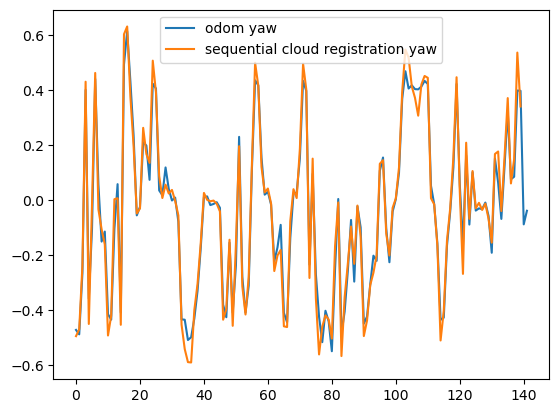

In [1715]:
fig, ax = p.subplots()   
odom_euls = np.zeros([0,3])
for i in range(1,len(odom_raw)):
#     rotm = R.from_quat(odom_raw[i,5:]).as_matrix()
    rotm = R.from_quat(odom_raw[i,5:]).as_dcm()
    rpy = np.array([np.arctan2(rotm[2,1],rotm[2,2]), np.arcsin(rotm[2,0]), np.arctan2(rotm[1,0], rotm[0,0])])
    odom_euls = np.append(odom_euls, rpy[None,:], axis = 0)

sr_euls = np.zeros([0,3])
for i in range(1,len(sr_raw)):
#     rotm = R.from_quat(sr_raw[i,5:]).as_matrix()
    rotm = R.from_quat(sr_raw[i,5:]).as_dcm()
    rpy = np.array([np.arctan2(rotm[2,1],rotm[2,2]), np.arcsin(rotm[2,0]), np.arctan2(rotm[1,0], rotm[0,0])])
    sr_euls = np.append(sr_euls, rpy[None,:], axis = 0)

ax.plot(odom_euls[1:,2], label = 'odom yaw')
ax.plot(sr_euls[:,2], label = 'sequential cloud registration yaw')
ax.legend(loc='best')

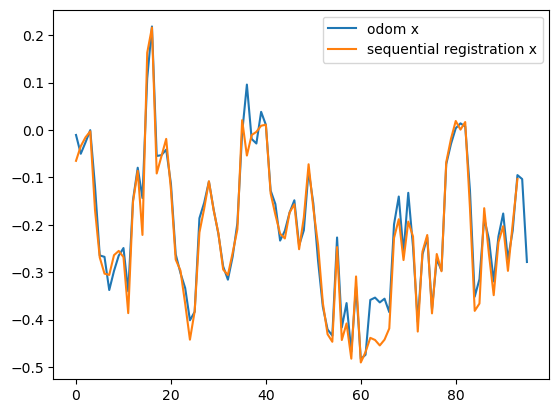

In [1693]:
fig, ax = p.subplots()
# print(odom_raw[:10,2:5], "\n \n", sr_raw[:10,2:5])
ax.plot(odom_raw[1:,2], label = 'odom x')
ax.plot(sr_raw[:,2], label = 'sequential registration x')
ax.legend(loc='best')

# Draw point clouds registered according to raw odometry and sequential keyframe registration

In [1694]:
#load keyframe point clouds
idx = 20
idx2 = idx + 1
# fn1 = "apartment/keyframe_" + str(idx) + ".csv"
# fn2 = "apartment/keyframe_" + str(idx2) + ".csv"
fn1 = "keyframe_" + str(idx) + ".csv"
fn2 = "keyframe_" + str(idx2) + ".csv"
pc1 = np.loadtxt(fn1, delimiter=",")
pc2 = np.loadtxt(fn2, delimiter=",")
# print(odom_raw[idx,2:5], R.from_quat(odom_raw[idx,5:]).as_euler('xyz'))
print(odom_raw[idx])

#get row corresponding to correct odometry constraint
odom_idx = np.where(odom_raw[:,0] == idx)[0][0]
sr_idx = np.where(sr_raw[:,0] == idx)[0][0]
print(odom_idx, sr_idx)

[20.         21.         -0.0414459   0.114531   -0.0186808   0.00559867
  0.01089    -0.210804   -0.977452  ]
20 19


In [1695]:
plt = Plotter(N = 2, axes = 0, bg = (0.2, 0.2, 0.2), interactive = True) #axes = 4 (simple), 1(scale)
disp_odom=[]
disp_odom.append(Points(pc1, c = 'red', r = 3, alpha = 0.5))
disp_odom.append(Points(pc2, c = 'blue', r = 3, alpha = 0.5))
disp_sr=[]
disp_sr.append(Points(pc1, c = 'red', r = 3, alpha = 0.5))
disp_sr.append(Points(pc2, c = 'blue', r = 3, alpha = 0.5))

# p2_p1f_odom = (pc2 - odom_raw[odom_idx,2:5]) @ R.from_quat(odom_raw[odom_idx,5:]).as_matrix()#works for odom output
# p2_p1f_sr = (pc2 - sr_raw[sr_idx,2:5]) @ R.from_quat(sr_raw[sr_idx,5:]).as_matrix()#works for odom output
p2_p1f_odom = (pc2 - odom_raw[odom_idx,2:5]) @ R.from_quat(odom_raw[odom_idx,5:]).as_dcm()#works for odom output
p2_p1f_sr = (pc2 - sr_raw[sr_idx,2:5]) @ R.from_quat(sr_raw[sr_idx,5:]).as_dcm()#works for odom output
disp_odom.append(Points(p2_p1f_odom, c = 'green', r = 3, alpha = 0.5))
disp_sr.append(Points(p2_p1f_sr, c = 'green', r = 3, alpha = 0.5))

plt.at(0).add(disp_odom, "odometry")              
plt.at(1).add(disp_sr, "loop closure between neighboring keyframes")              
plt.show()#"scan 1 (red), scan2 (blue), scan2 in s1 frame (green)" 

[vedo.plotter.py:909] WARNING: call to add() but Plotter was not initialized with show()
[vedo.plotter.py:909] WARNING: call to add() but Plotter was not initialized with show()
[vedo.plotter.py:3439] INFO: Closing window now. Plotter.escaped is set to True.


# Look at loop closure canidates (from scan context)

In [1696]:
print(len(lc_raw))

# np.where(lc_raw[:,0] == 58) 
# print(lc_raw[42,:2])

4


In [1697]:
lc_idx = 15
print(lc_raw[lc_idx,:])
idx = int((lc_raw[lc_idx,0]))
idx2 = int((lc_raw[lc_idx,1]))
print(idx, idx2)
print(R.from_quat(lc_raw[lc_idx,5:]).as_euler('xyz'))

# fn1 = "apartment/keyframe_" + str(idx) + ".csv"
# fn2 = "apartment/keyframe_" + str(idx2) + ".csv"
fn1 = "keyframe_" + str(idx) + ".csv"
fn2 = "keyframe_" + str(idx2) + ".csv"
pc1 = np.loadtxt(fn1, delimiter=",")
pc2 = np.loadtxt(fn2, delimiter=",")

plt = Plotter(N = 1, axes = 0, bg = (0.2, 0.2, 0.2), interactive = True)
disp = []
# p2_p1f_lc = (pc2 - lc_raw[lc_idx,2:5]) @ R.from_quat(lc_raw[lc_idx,5:]).as_matrix()
p2_p1f_lc = (pc2 - lc_raw[lc_idx,2:5]) @ R.from_quat(lc_raw[lc_idx,5:]).as_dcm()
disp.append(Points(p2_p1f_lc, c = 'green', r = 3, alpha = 0.5))

disp.append(Points(pc1, c = 'red', r = 3, alpha = 0.5))
disp.append(Points(pc2, c = 'blue', r = 3, alpha = 0.5))
plt.show(disp, "registering point clouds with scan context loop closure ") 

IndexError: index 15 is out of bounds for axis 0 with size 4

## Look at dense constraints

In [1203]:
# print(dc_raw)
print(len(dc_raw))

63


In [1699]:
dc_idx = 50
# print(dc_raw[dc_idx,:])
idx = int((dc_raw[dc_idx,0]))
idx2 = int((dc_raw[dc_idx,1]))
print(idx, idx2)
print(R.from_quat(dc_raw[dc_idx,5:]).as_euler('xyz'))

# fn1 = "apartment/keyframe_" + str(idx) + ".csv"
# fn2 = "apartment/keyframe_" + str(idx2) + ".csv"
fn1 = "keyframe_" + str(idx) + ".csv"
fn2 = "keyframe_" + str(idx2) + ".csv"
pc1 = np.loadtxt(fn1, delimiter=",")
pc2 = np.loadtxt(fn2, delimiter=",")

plt = Plotter(N = 1, axes = 0, bg = (0.2, 0.2, 0.2), interactive = True)
disp = []
p2_p1f_dc = (pc2 - dc_raw[dc_idx,2:5]) @ R.from_quat(dc_raw[dc_idx,5:]).as_dcm()
disp.append(Points(p2_p1f_dc, c = 'green', r = 3, alpha = 0.5))

disp.append(Points(pc1, c = 'red', r = 3, alpha = 0.5))
disp.append(Points(pc2, c = 'blue', r = 3, alpha = 0.5))
plt.show(disp, "registering point clouds with scan context loop closure ") 

30 49
[-0.00122663  0.03312528 -2.82678522]


[vedo.plotter.py:3439] INFO: Closing window now. Plotter.escaped is set to True.


# Optimize Sequential Keyframe trajectory + Loop Closure Constraints

### TODO:
* Combine SR with odom data
* replace batch GTSAM optimization with incramental iSAM2
* create new python node

In [1531]:
OH = np.zeros([len(sr_raw)+len(lc_raw),8])
for i in range(len(sr_raw)):
    OH[i,:3] = sr_raw[i,2:5]
    OH[i,3:6] = R.from_quat(sr_raw[i,5:]).as_euler('xyz')
    OH[i,6] = sr_raw[i,0] - 1
    OH[i,7] = sr_raw[i,1] - 1
for j in range(len(lc_raw)):
    OH[len(sr_raw)+j,:3] = lc_raw[j,2:5]
    OH[len(sr_raw)+j,3:6] = R.from_quat(lc_raw[j,5:]).as_euler('xyz')
    OH[len(sr_raw)+j,6] = lc_raw[j,0] - 1
    OH[len(sr_raw)+j,7] = lc_raw[j,1] - 1
    
    
odometry_history = OH
pred_stds_history = np.tile(np.array([[0.01, 0.01, 0.01, 1e-2, 1e-2, 1e-2]]), (len(odometry_history),1))

pred_stds_history[len(sr_raw):,:] *= 10 #make loop closure constraints way higher covariance

pred_stds_history = np.append(pred_stds_history, odometry_history[:,-2:], axis = 1)
ij = odometry_history[:,-2:].astype(np.int32)

In [1532]:
# Batch optimization
# Example constraint array: [x, y, z, roll, pitch, yaw, keyframe_idx1, keyframe_idx2]
constraints = odometry_history.copy()

# Initialize factor graph and values
graph = gtsam.NonlinearFactorGraph()
initial = gtsam.Values()

# Add a prior on the first keyframe to anchor the solution
prior_noise = gtsam.noiseModel.Diagonal.Sigmas([1e-3, 1e-3, 1e-3, 1e-3, 1e-3, 1e-3])  # Small uncertainty
# pose_prior = Pose3(Rot3.Identity(), Point3(0, 0, 0))
pose_prior = Pose3(Rot3.identity(), Point3(0, 0, 0))
graph.add(gtsam.PriorFactorPose3(0, pose_prior, prior_noise))

# Initialize first pose estimate
initial.insert(0, pose_prior)

# Add constraints and initialize other keyframes
for i, row in enumerate(constraints):
    x, y, z, roll, pitch, yaw, keyframe1, keyframe2 = row
    
    x *= -1 
    y *= -1 
    z *= -1 
    roll *= -1 
    pitch *= -1
    yaw *= -1
    
    # Convert quaternion to rotation matrix
    rot = Rot3.Ypr(yaw, pitch, roll)  # YPR order (Yaw-Pitch-Roll)
    
    # Create relative Pose3 transformation
    relative_pose = Pose3(rot, Point3(x, y, z))

    # Define a noise model (adjust values based on confidence in constraints)
#     constraint_noise = gtsam.noiseModel.Diagonal.Sigmas([0.1, 0.1, 0.1, 0.1, 0.1, 0.1])  
    constraint_noise = gtsam.noiseModel.Diagonal.Sigmas([pred_stds_history[i,0], 
                                                         pred_stds_history[i,1], 
                                                         pred_stds_history[i,2], 
                                                         pred_stds_history[i,3], 
                                                         pred_stds_history[i,4], 
                                                         pred_stds_history[i,5]])  

    # Add BetweenFactorPose3 for relative transformation
    #had this
    graph.add(gtsam.BetweenFactorPose3(int(keyframe1), int(keyframe2), relative_pose, constraint_noise))

    # Initialize poses (assuming incremental movement)
    if not initial.exists(int(keyframe2)):
        prev_pose = initial.atPose3(int(keyframe1))
        initial.insert(int(keyframe2), prev_pose.compose(relative_pose))

# Optimize
params = gtsam.DoglegParams()
params.setMaxIterations(100)
params.setVerbosity("Termination")
optimizer = gtsam.DoglegOptimizer(graph, initial, params)
result = optimizer.optimize()

# Print results
# for i in range(len(constraints) + 1):
#     print(f"Pose {i}: {result.atPose3(i)}")


converged
errorThreshold: 2426.35842888 <? 0
absoluteDecrease: 0 <? 1e-05
relativeDecrease: 0 <? 1e-05
iterations: 8 >? 100


In [1536]:
from pose_graph_utils import *

#Plot results
plt1 = Plotter(N = 1, axes = 1, bg =(1, 1, 1), interactive = True) #ax=7 gives rulers
disp = []
disp = plot_results(disp, result, ij, draw_axis=True) #draw without ellipsoids
# disp = plot_results(disp, result, ij, marginals, draw_axis = True) #draws covarince ellipsoids
plt1.show(disp, "Factor Graph Optmized Poses")

[vedo.plotter.py:3439] INFO: Closing window now. Plotter.escaped is set to True.


# Detect bad factors and run again

In [1678]:
#Only works with batch optimized graph (iSAM2 doesn't retain internal state in the same way)
def mahalanobis_distance(error, covariance):
    """Compute the Mahalanobis distance."""
    return error.T @ np.linalg.inv(covariance) @ error

def detect_bad_loop_closures(graph, result, threshold=20.0):
    bad_factors = []
    for i in range(graph.size()):
        factor = graph.at(i) 
        if isinstance(factor, gtsam.BetweenFactorPose3):
            key1, key2 = factor.keys()

            # Compute expected relative pose based on current estimate
            expected_pose = result.atPose3(key1).between(result.atPose3(key2))
            measured_pose = factor.measured()
            
            # Compute the relative transformation error
            error = gtsam.Pose3.Logmap(measured_pose.inverse() * expected_pose)

            # Get covariance from noise model
            covariance = factor.noiseModel().covariance()

            # Compute Mahalanobis distance
            mdist = mahalanobis_distance(error, covariance)

            if mdist > threshold:
                print(f"Bad loop closure detected: {key1} -> {key2} (Mahalanobis dist: {mdist:.2f})")
                bad_factors.append(i)  # Store index of the bad factor
    return bad_factors

def optimize_slam(graph, initial_estimate, thresh = 20.):
    """Optimize the SLAM graph and remove bad loop closures based on Mahalanobis distance."""
    optimizer = gtsam.LevenbergMarquardtOptimizer(graph, initial_estimate)
    result = optimizer.optimize()

    # Detect bad loop closures
    bad_factors = detect_bad_loop_closures(graph, result, thresh)

    if bad_factors:
        # Remove bad constraints
        new_graph = gtsam.NonlinearFactorGraph()
        for i in range(graph.size()):
            if i not in bad_factors:
                new_graph.add(graph.at(i))

        # Re-optimize with cleaned graph
        optimizer = gtsam.LevenbergMarquardtOptimizer(new_graph, initial_estimate)
        result = optimizer.optimize()

    return result

# Initialize estimates for keyframe positions from initial graph convergence
initial_estimate = gtsam.Values()
current_pose = gtsam.Pose3()
for i in range(graph.size()):
    factor = graph.at(i)
    if isinstance(factor, gtsam.BetweenFactorPose3):
        key1, key2 = factor.keys()  # Get the keys

        if not initial_estimate.exists(key1):  # Insert key1 if not already present
            initial_estimate.insert(key1, current_pose)

        # Apply odometry to get next pose
        current_pose = current_pose.compose(factor.measured())

        if not initial_estimate.exists(key2):  # FIX: Check before inserting key2
            initial_estimate.insert(key2, current_pose)

thresh = 100 #too low and we lose connectivity in our odometry chain
result = optimize_slam(graph, initial_estimate, thresh)

# Draw Keyframe Clouds on Optimized Trajectory 

In [1720]:
plt1 = Plotter(N = 1, axes = 0, bg =(1, 1, 1), interactive = True) #ax=7 gives rulers
disp = []

for i in range(2,result.size(), 1):
    t = result.atPose3(i).matrix()
    pc = np.loadtxt("keyframe_" + str(i+1) + ".csv",delimiter=",")
    pc4 = np.append(pc, np.ones([len(pc),1]), axis = 1)
    pc_wf = (t @ pc4.T).T    
    disp.append(Points(pc_wf[:,:3], c = 'gray', r=3, alpha = 0.05))
    disp.append(Points(t[:3,-1][None,:], c = 'red', r = 10))

plt1.show(disp, "Drawing Optimized Map")

[vedo.plotter.py:3439] INFO: Closing window now. Plotter.escaped is set to True.


# Repeat with incramental iSAM2 graph

In [1716]:
OH = np.zeros([len(sr_raw)+len(lc_raw),8])
# OH = np.zeros([len(sr_raw)+len(lc_raw)+len(odom_raw)-1,8])
for i in range(len(sr_raw)):
    OH[i,:3] = sr_raw[i,2:5]
    OH[i,3:6] = R.from_quat(sr_raw[i,5:]).as_euler('xyz')
    OH[i,6] = sr_raw[i,0] - 1
    OH[i,7] = sr_raw[i,1] - 1
for j in range(len(lc_raw)-1):
#     OLD-- not matching up with true trajectory(?)
    OH[len(sr_raw)+j,:3] = lc_raw[j,2:5]
    OH[len(sr_raw)+j,3:6] = R.from_quat(lc_raw[j,5:]).as_euler('xyz')
    OH[len(sr_raw)+j,6] = lc_raw[j,0] - 1
    OH[len(sr_raw)+j,7] = lc_raw[j,1] - 1

odometry_history = OH
pred_stds_history = np.tile(np.array([[0.01, 0.01, 0.01, 1e-2, 1e-2, 1e-2]]), (len(odometry_history),1))

pred_stds_history[len(sr_raw):,:] *= 10 #make loop closure constraints way higher covariance

pred_stds_history = np.append(pred_stds_history, odometry_history[:,-2:], axis = 1)
ij = odometry_history[:,-2:].astype(np.int32)

In [1717]:
#incramental optimization with iSAM2
# Example constraint array: [x, y, z, roll, pitch, yaw, keyframe_idx1, keyframe_idx2]
constraints = odometry_history.copy()

# Initialize iSAM2
parameters = gtsam.ISAM2Params()
isam = gtsam.ISAM2(parameters)

# Initialize factor graph and values
graph = gtsam.NonlinearFactorGraph()
initial = gtsam.Values()

# Add a prior on the first keyframe to anchor the solution
prior_noise = gtsam.noiseModel.Diagonal.Sigmas([1e-3] * 6)  # Small uncertainty
# pose_prior = Pose3(Rot3.Identity(), Point3(0, 0, 0))
pose_prior = Pose3(Rot3.identity(), Point3(0, 0, 0))
graph.add(gtsam.PriorFactorPose3(0, pose_prior, prior_noise))
initial.insert(0, pose_prior)  # Insert first keyframe

# Apply first update to initialize iSAM2
isam.update(graph, initial)
graph.resize(0)  # Clear graph after update
initial.clear()  # Clear values after inserting into iSAM2

# Process constraints iteratively
# for row in constraints:
for i, row in enumerate(constraints):
    x, y, z, roll, pitch, yaw, keyframe1, keyframe2 = row
    x *= -1
    y *= -1
    yaw *= -1  
#     #full 6 DOF
#     z *= -1
#     roll *= -1
#     pitch *= -1
#     PLANAR MOTION ONLY
    z *= 0
    roll *= 0
    pitch *= 0

    # Convert to Pose3 transformation
    rot = Rot3.Ypr(yaw, pitch, roll)  # YPR order (Yaw-Pitch-Roll)
    relative_pose = Pose3(rot, Point3(x, y, z))

    # Define a noise model
#     constraint_noise = gtsam.noiseModel.Diagonal.Sigmas([0.1] * 6) #uniform
    constraint_noise = gtsam.noiseModel.Diagonal.Sigmas([pred_stds_history[i,0], 
                                                         pred_stds_history[i,1], 
                                                         pred_stds_history[i,2], 
                                                         pred_stds_history[i,3], 
                                                         pred_stds_history[i,4], 
                                                         pred_stds_history[i,5]])  


    # Add BetweenFactorPose3 to graph
    graph.add(gtsam.BetweenFactorPose3(int(keyframe1), int(keyframe2), relative_pose, constraint_noise))

    # Prepare new values for iSAM2
    new_values = gtsam.Values()
    if not isam.valueExists(int(keyframe2)):  # Check if keyframe2 is new
        prev_pose = isam.calculateEstimate().atPose3(int(keyframe1))  # Get latest estimate
        new_values.insert(int(keyframe2), prev_pose.compose(relative_pose))

    # Update iSAM2 incrementally
    isam.update(graph, new_values)
    
    # Clear graph & values after update (iSAM2 retains internal state)
    graph.resize(0)
    new_values.clear()

result = isam.calculateEstimate()
# for i in range(int(np.max(constraints)) + 1):
#     print(f"Pose {i}: {result.atPose3(i)}")

In [1718]:
#Plot (initial) results
plt1 = Plotter(N = 1, axes = 1, bg =(1, 1, 1), interactive = True) #ax=7 gives rulers
disp = []
disp = plot_results(disp, result, ij, draw_axis=True) #draw without ellipsoids
# disp = plot_results(disp, result, ij, marginals, draw_axis = True) #draws covarince ellipsoids
plt1.show(disp, "Factor Graph Optmized Poses")

[vedo.plotter.py:3439] INFO: Closing window now. Plotter.escaped is set to True.


In [1677]:
print(lc_raw[:,:2])

[[ 27.  50.]
 [ 27.  51.]
 [ 24.  55.]
 [ 25.  55.]
 [ 24.  56.]
 [ 25.  57.]
 [ 24.  57.]
 [ 30.  57.]
 [ 25.  56.]
 [ 24.  59.]
 [ 28.  59.]
 [ 70.  92.]
 [ 68.  94.]
 [ 48.  60.]
 [104. 119.]
 [103. 119.]
 [102. 120.]
 [102. 122.]
 [103. 122.]
 [104. 122.]
 [103. 124.]
 [102. 124.]
 [102. 123.]
 [100. 126.]
 [100. 125.]
 [101. 120.]
 [103. 123.]
 [ 99. 126.]
 [137.  64.]
 [142.   1.]
 [143.   1.]]


# TODO-- find nearby keyframes not already in graph, use ICP to generate new loop closures

In [ ]:
skip_n = 10 #don't try do to loop closure constraints if we're less than this far apart
search_thresh = 1.
to_close = [] #keyframes that we should be able to add constraints for (they are close according to initial graph)
seeds = np.zeros([0,6]) #seeds for initial registration of scan j to scan i [x, y, z, r, p, y]
#loop through constraints (skip first?)
for i in range(1,np.max(ij)):
    ci = result.atPose3(i).translation() #center i
    for j in range(i+skip_n, np.max(ij)+1):
        cj = result.atPose3(j).translation() #center j
        d = sqrt(sum((ci-cj)**2))
        if d < search_thresh:
            to_close.append([i,j])
            rotm_i = result.atPose3(i).matrix()
            rotm_j = result.atPose3(j).matrix()
            rotm_relative = np.linalg.pinv(rotm_i) @ rotm_j
            rpy = R.from_matrix(rotm_relative[:3,:3]).as_euler('xyz')
            seed = np.array([[rotm_relative[0,-1], rotm_relative[1,-1], rotm_relative[2,-1], rpy[0], rpy[1], rpy[2]]])
            seeds = np.append(seeds, seed, axis = 0)
            
print(len(to_close))
print(to_close)
print(seeds[20])

In [ ]:
#debug initial seeds for loop closure
idx = 100
print(to_close[idx])
print(seeds[idx])

fn1 = "apartment/keyframe_" + str(to_close[idx][0]+1) + ".csv"
fn2 = "apartment/keyframe_" + str(to_close[idx][1]+1) + ".csv"
# fn1 = "keyframe_" + str(to_close[idx][0]+1) + ".csv"
# fn2 = "keyframe_" + str(to_close[idx][1]+1) + ".csv"
pc1 = np.loadtxt(fn1, delimiter=",")
pc2 = np.loadtxt(fn2, delimiter=",")

plt = Plotter(N = 1, axes = 0, bg = (0.2, 0.2, 0.2), interactive = True)
disp = []
p2_p1f_lc = (pc2 - seeds[idx,:3]) @ R.from_euler('xyz',-seeds[idx,3:]).as_matrix()
disp.append(Points(p2_p1f_lc, c = 'green', r = 3, alpha = 0.5))

disp.append(Points(pc1, c = 'red', r = 3, alpha = 0.5))
disp.append(Points(pc2, c = 'blue', r = 3, alpha = 0.5))
plt.show(disp, "using graph solution to seed ICP for generating new constraints") 

In [ ]:
#remove bad factors
import gtsam
import numpy as np
from gtsam import Pose3, Rot3, Point3

def detect_bad_loop_closures(added_factors, result, threshold=20.0):
    """Detect loop closures with high Mahalanobis distance."""
    bad_factors = []
    
    for i, factor in enumerate(added_factors):
        if isinstance(factor, gtsam.BetweenFactorPose3):
            key1, key2 = factor.keys()
            
            # Get poses from the result
            pose1 = result.atPose3(key1)
            pose2 = result.atPose3(key2)
            
            # Get the measured relative pose from the factor
            measured_pose = factor.measured()
            
            # Compute the expected relative pose based on current estimate
            expected_pose = pose1.between(pose2)
            
            # Compute error: difference between measured and expected
            error = gtsam.Pose3.Logmap(measured_pose.between(expected_pose.inverse()))
            
            # Convert GTSAM vector to numpy array
            error_np = np.array([error[i] for i in range(6)])
            
            # Get the noise model from the factor
            noise_model = factor.noiseModel()
            
            # Convert information matrix to covariance
            # For a Diagonal noise model, we can use:
            if isinstance(noise_model, gtsam.noiseModel.Diagonal):
                # Get sigmas (square root of diagonal of covariance)
                sigmas = np.array([noise_model.sigmas()[i] for i in range(6)])
                # Square to get variances
                variances = sigmas ** 2
                # Create diagonal covariance matrix
                covariance = np.diag(variances)
            else:
                # For other noise models, this is an approximation
                info = np.eye(6)  # Default to identity if we can't get info matrix
                covariance = np.linalg.inv(info)
            
            # Compute Mahalanobis distance
            mdist = np.sqrt(error_np.T @ np.linalg.inv(covariance) @ error_np)
            
            if mdist > threshold:
                print(f"Bad loop closure detected: {key1} -> {key2} (Mahalanobis dist: {mdist:.2f})")
                bad_factors.append(i)  # Store index of the bad factor
    
    return bad_factors

#DEBUG HERE~~~~~~~~~~~~~~~~~~~~~~~~~
# Initialize iSAM2 and other structures
parameters = gtsam.ISAM2Params()
isam = gtsam.ISAM2(parameters)

# Initialize the graph and initial values
graph = gtsam.NonlinearFactorGraph()
initial = gtsam.Values()
added_factors = []  # List to keep track of the added factors

# Identify the first keyframe appearing in constraints (get the min keyframe)
first_keyframe = min(int(row[6]) for row in odometry_history)

# Add a prior on the first keyframe to anchor the solution
prior_noise = gtsam.noiseModel.Diagonal.Sigmas([1e-3] * 6)  # Small uncertainty
pose_prior = gtsam.Pose3(gtsam.Rot3.Identity(), gtsam.Point3(0, 0, 0))
graph.add(gtsam.PriorFactorPose3(first_keyframe, pose_prior, prior_noise))
initial.insert(first_keyframe, pose_prior)  # Make sure the first keyframe is initialized

# Now, process the constraints and add them incrementally
for row in odometry_history:
    x, y, z, roll, pitch, yaw, keyframe1, keyframe2 = row
    x *= -1
    y *= -1
    z *= -1
    roll *= -1
    pitch *= -1
    yaw *= -1  
    
    keyframe1, keyframe2 = int(keyframe1), int(keyframe2)

    # Ensure keyframe1 is initialized before we process the constraint
    if not initial.exists(keyframe1):
        print(f"Skipping constraint {keyframe1} -> {keyframe2} (keyframe1 not initialized yet)")
        continue  # Skip this constraint if keyframe1 is not initialized yet

    # Convert to Pose3 transformation
    rot = gtsam.Rot3.Ypr(yaw, pitch, roll)
    relative_pose = gtsam.Pose3(rot, gtsam.Point3(x, y, z))

    # Define a noise model for the constraint
    constraint_noise = gtsam.noiseModel.Diagonal.Sigmas([0.1] * 6)

    # Add the BetweenFactorPose3 constraint
    factor = gtsam.BetweenFactorPose3(keyframe1, keyframe2, relative_pose, constraint_noise)
    graph.add(factor)
    added_factors.append(factor)

    # Initialize keyframe2 if not already present
    if not initial.exists(keyframe2):
        prev_pose = initial.atPose3(keyframe1)  # This will now always exist
        new_pose = prev_pose.compose(relative_pose)
        initial.insert(keyframe2, new_pose)

# Update iSAM2 incrementally with the factors and initial values
isam.update(graph, initial)

# Now, calculate the current estimate using iSAM2
result = isam.calculateEstimate()

# Clear graph and initial values after update (iSAM2 retains internal state)
graph = gtsam.NonlinearFactorGraph()
initial = gtsam.Values()

# After optimization, detect and remove bad loop closures
thresh = 20  # Threshold for bad loop closures
bad_factors = detect_bad_loop_closures(added_factors, result, thresh)
print(bad_factors)
# After detecting bad loop closures
if bad_factors:
    print(f"Removing {len(bad_factors)} bad constraints and re-optimizing...")

    # Rebuild the graph without the bad factors
    graph = gtsam.NonlinearFactorGraph()
    new_factors = [f for i, f in enumerate(added_factors) if i not in bad_factors]
    
    # Add prior factor to anchor the solution
    graph.add(gtsam.PriorFactorPose3(first_keyframe, pose_prior, prior_noise))
    
    # Add the good factors back to the graph
    for factor in new_factors:
        graph.add(factor)

    # Start with the first keyframe as initial value
    initial = gtsam.Values()
    initial.insert(first_keyframe, pose_prior)
    
    # Initialize other keyframes based on good constraints
    initialized_keys = {first_keyframe}
    
    # Keep trying to initialize keyframes until no more can be initialized
    progress = True
    while progress:
        progress = False
        for factor in new_factors:
            if isinstance(factor, gtsam.BetweenFactorPose3):
                key1, key2 = factor.keys()
                
                # If key1 is initialized but key2 is not
                if key1 in initialized_keys and key2 not in initialized_keys:
                    prev_pose = initial.atPose3(key1)
                    new_pose = prev_pose.compose(factor.measured())
                    initial.insert(key2, new_pose)
                    initialized_keys.add(key2)
                    progress = True
                
                # If key2 is initialized but key1 is not
                elif key2 in initialized_keys and key1 not in initialized_keys:
                    prev_pose = initial.atPose3(key2)
                    new_pose = prev_pose.compose(factor.measured().inverse())
                    initial.insert(key1, new_pose)
                    initialized_keys.add(key1)
                    progress = True
    
    # Re-initialize iSAM2 with the cleaned graph and initial estimate
    isam = gtsam.ISAM2(parameters)
    isam.update(graph, initial)
    result = isam.calculateEstimate()

# # Print final poses for debugging
# for i in range(len(odometry_history) + 1):
#     if result.exists(i):
#         print(f"Pose {i}: {result.atPose3(i)}")

In [ ]:
# print(graph.keys())
# print(initial.keys())
# print(initial)
# print(graph.nrFactors)
# graph.nrFactor
# graph.print()

In [ ]:
# # Create an empty nonlinear factor graph
# graph = gtsam.NonlinearFactorGraph() 

# # Add a prior on the first pose, setting it to the origin
# priorRot = gtsam.Rot3(R_tf(np.array([0., 0., 0.])))
# priorMean = gtsam.Pose3(priorRot, np.array([0., 0., .0])) #prior at nonzero pose
# PRIOR_NOISE = gtsam.noiseModel.Diagonal.Sigmas(
#     np.array([0.003, 0.003, 0.003, 1e-5, 1e-5, 1e-5], dtype = np.float64))
# graph.add(gtsam.PriorFactorPose3(0, priorMean, PRIOR_NOISE)) #constrain first point at priorMean

# #loop through all constraints 
# for i in range(len(ij)):
#     rot = gtsam.Rot3(R_tf(odometry_history[i,3:7]))    #convert to Point3 strucutre
#     transform = gtsam.Pose3(rot, odometry_history[i,:3])
#     cov_estimate = gtsam.noiseModel.Diagonal.Sigmas(pred_stds_history[i,:-2])
#     graph.add(gtsam.BetweenFactorPose3(ij[i,0], ij[i,1], transform, cov_estimate))

# #set initial conditions
# initial = gtsam.Values()
# print("\n graph size:", graph.size(), "max ij", np.max(ij))
# # for j in range(graph.size()):
# for j in range(int(np.max(ij))+1):
# #     init_rot = gtsam.Rot3(sr[j-1,:3,:3])
# #     init_pose = gtsam.Pose3(init_rot, -sr[j-1,:3,3])
#     init_rot = gtsam.Rot3(0.01*np.random.randn(3))
# #     init_pose = gtsam.Pose3(init_rot, 1.*np.random.randn(3))
#     init_pose = gtsam.Pose3(init_rot, j*odometry_history[i,:3])
#     initial.insert(j, init_pose)
    
# # # optimize using Levenberg-Marquardt optimization
# # # damped optimizer - seems to work much better here
# # params = gtsam.LevenbergMarquardtParams()
# # optimizer = gtsam.LevenbergMarquardtOptimizer(graph, initial, params)

# # # simple gauss newton - kinda unreliable for high DOF problems (especially with zero initial conditions)
# # params = gtsam.GaussNewtonParams()
# # params.setVerbosity("Termination")  # this will show info about stopping conds
# # optimizer = gtsam.GaussNewtonOptimizer(graph, initial, params)

# # dogleg
# params = gtsam.DoglegParams()
# params.setVerbosity("Termination")
# params.setMaxIterations(10)
# optimizer = gtsam.DoglegOptimizer(graph, initial, params)

# result = optimizer.optimize()
# marginals = gtsam.Marginals(graph, result) #calculate covariance estimates for each pose

# print("initial error = ", graph.error(initial))
# print("final error = ", graph.error(result))
# # print(initial.keys())
# # print(graph.keys())